## Bernoulli Randomization Experiments

In [1]:
import csv
import math
import random
import pandas as pd

# --- Configuration Constants ---
DEPARTURE_RATE_MU_BASE = 20

# Prices for the Bernoulli experiment
PRICE_CONTROL = 0.25        # p0
PRICE_TREATMENT = 1.75      # p1
PROB_Q_TREATMENT = 0.5     # Probability of choosing PRICE_TREATMENT

A_FACTORS = {              
    1: 0.9, 2: 1.0, 3: 1.1, 4: 1.2
}
SIMULATION_WEEKS = 4
DAYS_PER_WEEK = 7
HOURS_PER_DAY = 24
TOTAL_SIM_HOURS = float(SIMULATION_WEEKS * DAYS_PER_WEEK * HOURS_PER_DAY)

UNIF_TIME_STEP_MINUTES = 1
DELTA_T_HOURS = UNIF_TIME_STEP_MINUTES / 60.0 
R_UNIF = 1.0 / DELTA_T_HOURS

# Number of simulation replications
NUM_SIMULATION_RUNS = 500  # For the randomized experiment output file
NUM_ORACLE_RUNS = 500      # For calculating "true" ATE

# Random Seeds for reproducibility
SEED_MAIN_EXPERIMENTS = 42    # Seed for the 500 randomized experiment runs
SEED_ORACLE_CALCULATION = 123 # Seed for the 500+500 oracle runs for true ATE

# --- Function to Load and Prepare Base Arrival Rates (b_d,t) ---
def load_b_rates(filename="data0.csv"):
    try:
        df = pd.read_csv(filename, header=None, encoding='utf-8-sig')
    except Exception as e:
        print(f"Warning: CSV reading with 'utf-8-sig' failed ({e}). Trying default encoding.")
        df = pd.read_csv(filename, header=None)
    df.columns = ['time_csv', 'rate_b', 'day_str', 'day_numeric']
    b_rates_lookup = {}
    for day_idx, group in df.groupby('day_numeric'):
        b_rates_lookup[day_idx] = dict(zip(group['time_csv'].astype(float), group['rate_b']))
    return b_rates_lookup

# --- Helper Function to Get Current Base Arrival Rate b_d,t ---
def get_base_arrival_rate_b_dt(b_rates_lookup, day_numeric_idx, time_within_day_current):
    if time_within_day_current >= HOURS_PER_DAY:
        time_within_day_current = 0.0 
    time_slot_index = math.floor(time_within_day_current / 0.5)
    time_csv_key = (time_slot_index * 0.5) + 0.5
    time_csv_key = float(time_csv_key)
    try:
        return b_rates_lookup[day_numeric_idx][time_csv_key]
    except KeyError:
        day_keys = b_rates_lookup.get(day_numeric_idx, {})
        max_key_for_day = max(day_keys.keys()) if day_keys else -1
        if time_csv_key > max_key_for_day and abs(time_csv_key - (max_key_for_day + 0.5)) < 1e-9 :
             return day_keys[max_key_for_day]
        raise ValueError(
            f"Failed to lookup b_rate for day_idx={day_numeric_idx}, query_time_key={time_csv_key} "
            f"(derived from time_within_day={time_within_day_current}). "
            f"Available keys: {sorted(list(day_keys.keys())) if day_keys else 'None'}"
        )

# --- Simulation function for randomized experiment ---
def simulate_uniformized_queue_experiment(base_b_rates, initial_queue_length=0):
    current_k = initial_queue_length
    simulation_log = [] 
    num_steps = int(round(TOTAL_SIM_HOURS / DELTA_T_HOURS))

    for step_idx in range(num_steps):
        current_T_start_of_step = step_idx * DELTA_T_HOURS
        abs_day_number = math.floor(current_T_start_of_step / HOURS_PER_DAY)
        time_within_day = current_T_start_of_step % HOURS_PER_DAY
        current_week_num = math.floor(abs_day_number / DAYS_PER_WEEK) + 1
        day_of_week_idx = abs_day_number % DAYS_PER_WEEK
        
        a_w = A_FACTORS[min(current_week_num, max(A_FACTORS.keys()))]
        b_dt_rate = get_base_arrival_rate_b_dt(base_b_rates, day_of_week_idx, time_within_day)

        Z_t = 0 
        chosen_price = PRICE_CONTROL
        if random.random() < PROB_Q_TREATMENT:
            chosen_price = PRICE_TREATMENT
            Z_t = 1

        price_effect_term = 2.0 - chosen_price
        if price_effect_term < 0: price_effect_term = 0 
        arrival_rate_lambda_k = (4.0 * price_effect_term / (1.0 + 0.2 * current_k)) * a_w * b_dt_rate

        if arrival_rate_lambda_k < 0: arrival_rate_lambda_k = 0.0
        departure_rate_mu_k = DEPARTURE_RATE_MU_BASE if current_k > 0 else 0.0
        
        total_natural_rate = arrival_rate_lambda_k + departure_rate_mu_k
        prob_arrival, prob_departure, prob_self_loop = 0.0, 0.0, 1.0

        if total_natural_rate > 0:
            if total_natural_rate > R_UNIF:
                prob_arrival = arrival_rate_lambda_k / total_natural_rate
                prob_departure = departure_rate_mu_k / total_natural_rate
                prob_self_loop = 0.0
            else:
                prob_arrival = arrival_rate_lambda_k / R_UNIF
                prob_departure = departure_rate_mu_k / R_UNIF
                prob_self_loop = 1.0 - prob_arrival - prob_departure
        if prob_self_loop < 0: prob_self_loop = 0.0

        rand_draw = random.random()
        if rand_draw < prob_arrival: current_k += 1
        elif rand_draw < prob_arrival + prob_departure:
            if current_k > 0: current_k -= 1
        
        time_at_end_of_step = (step_idx + 1) * DELTA_T_HOURS
        simulation_log.append((time_at_end_of_step, Z_t, current_k))
        
    return simulation_log

# --- New simulation function for fixed price scenarios (for "True" ATE) ---
def simulate_fixed_price_run_and_get_sum_Y_and_steps(base_b_rates, initial_queue_length, fixed_price_to_use):
    current_k = initial_queue_length
    sum_Y_t_for_run = 0
    num_steps_in_run = int(round(TOTAL_SIM_HOURS / DELTA_T_HOURS))

    for step_idx in range(num_steps_in_run):
        current_T_start_of_step = step_idx * DELTA_T_HOURS
        abs_day_number = math.floor(current_T_start_of_step / HOURS_PER_DAY)
        time_within_day = current_T_start_of_step % HOURS_PER_DAY
        current_week_num = math.floor(abs_day_number / DAYS_PER_WEEK) + 1
        day_of_week_idx = abs_day_number % DAYS_PER_WEEK
        
        a_w = A_FACTORS[min(current_week_num, max(A_FACTORS.keys()))]
        b_dt_rate = get_base_arrival_rate_b_dt(base_b_rates, day_of_week_idx, time_within_day)

        chosen_price = fixed_price_to_use # Price is fixed

        price_effect_term = 2.0 - chosen_price
        if price_effect_term < 0: price_effect_term = 0 
        arrival_rate_lambda_k = (4.0 * price_effect_term / (1.0 + current_k)) * a_w * b_dt_rate
        if arrival_rate_lambda_k < 0: arrival_rate_lambda_k = 0.0
        departure_rate_mu_k = DEPARTURE_RATE_MU_BASE if current_k > 0 else 0.0
        
        total_natural_rate = arrival_rate_lambda_k + departure_rate_mu_k
        prob_arrival, prob_departure, prob_self_loop = 0.0, 0.0, 1.0

        if total_natural_rate > 0:
            if total_natural_rate > R_UNIF:
                prob_arrival = arrival_rate_lambda_k / total_natural_rate
                prob_departure = departure_rate_mu_k / total_natural_rate
                prob_self_loop = 0.0
            else:
                prob_arrival = arrival_rate_lambda_k / R_UNIF
                prob_departure = departure_rate_mu_k / R_UNIF
                prob_self_loop = 1.0 - prob_arrival - prob_departure
        if prob_self_loop < 0: prob_self_loop = 0.0
        
        rand_draw = random.random()
        if rand_draw < prob_arrival: current_k += 1
        elif rand_draw < prob_arrival + prob_departure:
            if current_k > 0: current_k -= 1
        
        sum_Y_t_for_run += current_k
        
    return sum_Y_t_for_run, num_steps_in_run

# # --- Main Execution Block ---
print("Loading base arrival rates (b_d,t) from data0.csv...")
base_b_rates_data = load_b_rates("data0.csv")
print("Base arrival rates loaded successfully.")

# --- Part 1: Run multiple copies of the randomized experiment and save history ---
print(f"\n--- Running {NUM_SIMULATION_RUNS} Randomized Experiment Simulations ---")
random.seed(SEED_MAIN_EXPERIMENTS) # Seed for this block of experiments

output_csv_filename = "outcomes/uniformized_simulation_experiment_output_multi_run.csv"
print(f"Saving full simulation history for {NUM_SIMULATION_RUNS} runs to: {output_csv_filename}")

try:
    with open(output_csv_filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(["RunID", "TimeAtEndOfStep_Hours", "TreatmentIndicator_Zt", "QueueLength_Yt"])
        
        for run_id in range(NUM_SIMULATION_RUNS):
            if (run_id + 1) % 50 == 0 or run_id == 0: # Print progress
                print(f"  Starting randomized experiment run {run_id + 1} of {NUM_SIMULATION_RUNS}...")
            
            # Each run uses a subsequent part of the random number stream
            single_run_history = simulate_uniformized_queue_experiment(
                base_b_rates_data, 
                initial_queue_length=0
            )
            for time_val, Z_val, Y_val in single_run_history:
                csv_writer.writerow([run_id, f"{time_val:.6f}", Z_val, Y_val])
    print(f"Randomized experiment histories successfully saved to {output_csv_filename}.")
except IOError:
    print(f"Error: Could not write simulation history to {output_csv_filename}.")

print("Completed randomized experiment simulations.")

# --- Part 2: Calculate "True" Average Treatment Effect (ATE) ---
print(f"\n--- Calculating 'True' Average Treatment Effect using {NUM_ORACLE_RUNS} runs per scenario ---")
random.seed(SEED_ORACLE_CALCULATION) # Use a different seed for this oracle block

# Calculate True Mean under Treatment (mu_1_true)
grand_total_Y_treatment = 0
grand_total_steps_treatment = 0
print(f"  Simulating {NUM_ORACLE_RUNS} runs for PRICE_TREATMENT ({PRICE_TREATMENT})...")
for i in range(NUM_ORACLE_RUNS):
    if (i + 1) % 50 == 0 or i == 0: # Print progress
        print(f"    Treatment run {i + 1} of {NUM_ORACLE_RUNS}...")
    sum_y, num_s = simulate_fixed_price_run_and_get_sum_Y_and_steps(
        base_b_rates_data, 
        initial_queue_length=0, 
        fixed_price_to_use=PRICE_TREATMENT
    )
    grand_total_Y_treatment += sum_y
    grand_total_steps_treatment += num_s

mu1_true = (grand_total_Y_treatment / grand_total_steps_treatment) if grand_total_steps_treatment > 0 else float('nan')
print(f"  Calculated True Mean Queue Length under Treatment (mu_1_true): {mu1_true:.6f}")

# Calculate True Mean under Control (mu_0_true)
grand_total_Y_control = 0
grand_total_steps_control = 0
print(f"\n  Simulating {NUM_ORACLE_RUNS} runs for PRICE_CONTROL ({PRICE_CONTROL})...")
for i in range(NUM_ORACLE_RUNS):
    if (i + 1) % 50 == 0 or i == 0: # Print progress
        print(f"    Control run {i + 1} of {NUM_ORACLE_RUNS}...")
    sum_y, num_s = simulate_fixed_price_run_and_get_sum_Y_and_steps(
        base_b_rates_data, 
        initial_queue_length=0, 
        fixed_price_to_use=PRICE_CONTROL
    )
    grand_total_Y_control += sum_y
    grand_total_steps_control += num_s

mu0_true = (grand_total_Y_control / grand_total_steps_control) if grand_total_steps_control > 0 else float('nan')
print(f"  Calculated True Mean Queue Length under Control (mu_0_true): {mu0_true:.6f}")

# Calculate "True" ATE
true_ATE = mu1_true - mu0_true
print(f"\n  'True' Average Treatment Effect (ATE = mu_1_true - mu_0_true): {true_ATE:.6f}")
print("Completed 'True' ATE calculation.")

Loading base arrival rates (b_d,t) from data0.csv...
Base arrival rates loaded successfully.

--- Running 500 Randomized Experiment Simulations ---
Saving full simulation history for 500 runs to: outcomes/uniformized_simulation_experiment_output_multi_run.csv
  Starting randomized experiment run 1 of 500...
  Starting randomized experiment run 50 of 500...
  Starting randomized experiment run 100 of 500...
  Starting randomized experiment run 150 of 500...
  Starting randomized experiment run 200 of 500...
  Starting randomized experiment run 250 of 500...
  Starting randomized experiment run 300 of 500...
  Starting randomized experiment run 350 of 500...
  Starting randomized experiment run 400 of 500...
  Starting randomized experiment run 450 of 500...
  Starting randomized experiment run 500 of 500...
Randomized experiment histories successfully saved to outcomes/uniformized_simulation_experiment_output_multi_run.csv.
Completed randomized experiment simulations.

--- Calculating '

## Bernoulli Switchback Experiments

In [2]:
import csv
import math
import random
import pandas as pd

# --- Configuration Constants ---
DEPARTURE_RATE_MU_BASE = 20

# Prices for the Bernoulli experiment
PRICE_CONTROL = 0.25        # p0
PRICE_TREATMENT = 1.75      # p1
PROB_Q_TREATMENT = 0.5     # Probability of choosing PRICE_TREATMENT

A_FACTORS = {1: 0.9, 2: 1.0, 3: 1.1, 4: 1.2}
SIMULATION_WEEKS = 4
DAYS_PER_WEEK = 7
HOURS_PER_DAY = 24
TOTAL_SIM_HOURS = SIMULATION_WEEKS * DAYS_PER_WEEK * HOURS_PER_DAY

UNIF_TIME_STEP_MINUTES = 1
DELTA_T_HOURS = UNIF_TIME_STEP_MINUTES / 60.0
R_UNIF = 1.0 / DELTA_T_HOURS

NUM_SIMULATION_RUNS = 500
SEED_MAIN_EXPERIMENTS = 42
SWITCHBACK_INTERVAL_MINUTES = 60

# --- Load base arrival rate ---
def load_b_rates(filename="data0.csv"):
    df = pd.read_csv(filename, header=None)
    df.columns = ['time_csv', 'rate_b', 'day_str', 'day_numeric']
    b_rates_lookup = {}
    for day_idx, group in df.groupby('day_numeric'):
        b_rates_lookup[day_idx] = dict(zip(group['time_csv'].astype(float), group['rate_b']))
    return b_rates_lookup

# --- Get b_d,t ---
def get_base_arrival_rate_b_dt(b_rates_lookup, day_numeric_idx, time_within_day_current):
    if time_within_day_current >= HOURS_PER_DAY:
        time_within_day_current = 0.0
    time_slot_index = math.floor(time_within_day_current / 0.5)
    time_csv_key = (time_slot_index * 0.5) + 0.5
    return b_rates_lookup[day_numeric_idx].get(time_csv_key, 0.0)

# --- Generate switchback treatment assignment ---
def generate_switchback_schedule(num_steps, steps_per_interval, seed):
    random.seed(seed)
    schedule = []
    current = random.choice([0, 1])
    for i in range(0, num_steps, steps_per_interval):
        if random.random() < 0.5:
            current = 1 - current
        schedule.extend([current] * min(steps_per_interval, num_steps - len(schedule)))
    return schedule

# --- Simulate queue ---
def simulate_queue(base_b_rates, Z_schedule, initial_k=0):
    log = []
    k = initial_k
    for step_idx, Z_t in enumerate(Z_schedule):
        time_hr = step_idx * DELTA_T_HOURS
        abs_day = math.floor(time_hr / HOURS_PER_DAY)
        time_in_day = time_hr % HOURS_PER_DAY
        week_num = math.floor(abs_day / DAYS_PER_WEEK) + 1
        day_idx = abs_day % DAYS_PER_WEEK

        a_w = A_FACTORS[min(week_num, max(A_FACTORS.keys()))]
        b_dt = get_base_arrival_rate_b_dt(base_b_rates, day_idx, time_in_day)
        price = PRICE_TREATMENT if Z_t == 1 else PRICE_CONTROL
        price_effect = max(0, 2.0 - price)
        lambda_k = (4.0 * price_effect / (1.0 + 0.2 * k)) * a_w * b_dt
        mu_k = DEPARTURE_RATE_MU_BASE if k > 0 else 0.0

        total_rate = lambda_k + mu_k
        if total_rate > R_UNIF:
            p_arr = lambda_k / total_rate
            p_dep = mu_k / total_rate
            p_self = 0.0
        else:
            p_arr = lambda_k / R_UNIF
            p_dep = mu_k / R_UNIF
            p_self = max(0.0, 1.0 - p_arr - p_dep)

        r = random.random()
        if r < p_arr:
            k += 1
        elif r < p_arr + p_dep:
            k = max(0, k - 1)

        log.append((time_hr + DELTA_T_HOURS, Z_t, k))
    return log

# --- Main ---
if __name__ == "__main__":
    print("Loading base arrival rates...")
    base_b = load_b_rates("data0.csv")
    print("Base arrival rates loaded.")

    num_steps = int(TOTAL_SIM_HOURS / DELTA_T_HOURS)
    interval_steps = int(SWITCHBACK_INTERVAL_MINUTES / UNIF_TIME_STEP_MINUTES)
    output_file = "outcomes/switchback_simulation_experiment_output_multi_run.csv"

    print(f"Running {NUM_SIMULATION_RUNS} switchback simulations...")
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["RunID", "TimeAtEndOfStep_Hours", "TreatmentIndicator_Zt", "QueueLength_Yt"])

        for run_id in range(NUM_SIMULATION_RUNS):
            if run_id % 50 == 0:
                print(f"  Run {run_id+1}/{NUM_SIMULATION_RUNS}")
            Z_sched = generate_switchback_schedule(num_steps, interval_steps, seed=SEED_MAIN_EXPERIMENTS + run_id)
            hist = simulate_queue(base_b, Z_sched)
            for t, z, y in hist:
                writer.writerow([run_id, f"{t:.6f}", z, y])

    print(f"Switchback outcomes saved to {output_file}.")


Loading base arrival rates...
Base arrival rates loaded.
Running 500 switchback simulations...
  Run 1/500
  Run 51/500
  Run 101/500
  Run 151/500
  Run 201/500
  Run 251/500
  Run 301/500
  Run 351/500
  Run 401/500
  Run 451/500
Switchback outcomes saved to outcomes/switchback_simulation_experiment_output_multi_run.csv.


## Estimation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import Ridge

# --- Configuration ---
CSV_INPUT_FILENAME_HT = "outcomes/uniformized_simulation_experiment_output_multi_run.csv"
CSV_INPUT_FILENAME_DM = "outcomes/switchback_simulation_experiment_output_multi_run.csv"
SWITCHBACK_INTERVAL_MINUTES = 60

# --- Estimators ---
def calculate_truncated_dq_estimator(simulation_history, q, k):
    if not simulation_history or not (0 < q < 1):
        return None, None, None
    N = len(simulation_history)
    Y = [y for _, _, y in simulation_history]
    Z = [z for _, z, _ in simulation_history]
    one_minus_q = 1.0 - q
    s1 = sum((Z[t] * sum(Y[t:min(t + k + 1, N)]) / q) for t in range(N))
    s0 = sum(((1 - Z[t]) * sum(Y[t:min(t + k + 1, N)]) / one_minus_q) for t in range(N))
    return s1 / N, s0 / N, (s1 - s0) / N

def calculate_switchback_dm_estimator(df, interval_minutes=SWITCHBACK_INTERVAL_MINUTES):
    df = df.copy()
    df['TimeAtEndOfStep_Hours'] = pd.to_datetime(df['TimeAtEndOfStep_Hours'] * 3600, unit='s')
    df = df.sort_values('TimeAtEndOfStep_Hours')
    df['block'] = (df['TimeAtEndOfStep_Hours'].astype(np.int64) // (interval_minutes * 60 * 1e9)).astype(int)
    treated = df[df['TreatmentIndicator_Zt'] == 1].groupby('block')['QueueLength_Yt'].mean()
    control = df[df['TreatmentIndicator_Zt'] == 0].groupby('block')['QueueLength_Yt'].mean()
    common_blocks = treated.index.intersection(control.index)
    block_diffs = treated.loc[common_blocks] - control.loc[common_blocks]
    return block_diffs.mean()

def compute_bias_corrected_switchback_ate(df, burn_in_minutes=5, block_minutes=60):
    df = df.copy()
    df['ts'] = pd.to_datetime(df['TimeAtEndOfStep_Hours'] * 3600, unit='s')
    block_duration = pd.Timedelta(minutes=block_minutes)
    df['block_start'] = df['ts'].dt.floor(f'{block_minutes}min')
    df['block'] = df['block_start'].rank(method='dense').astype(int) - 1
    df['block_time'] = df['ts'] - df['block_start']
    df['in_focal'] = df['block_time'] > pd.Timedelta(minutes=burn_in_minutes)
    focal = df[df['in_focal']]
    mu1 = focal[focal['TreatmentIndicator_Zt'] == 1]['QueueLength_Yt'].mean()
    mu0 = focal[focal['TreatmentIndicator_Zt'] == 0]['QueueLength_Yt'].mean()
    tau_dm = mu1 - mu0
    block_treat = df.groupby('block').first()['TreatmentIndicator_Zt'].astype(int)
    block_treat_prev = block_treat.shift()
    k11_blocks = block_treat[(block_treat == 1) & (block_treat_prev == 1)].index
    k00_blocks = block_treat[(block_treat == 0) & (block_treat_prev == 0)].index

    def burnin_avg(block_ids):
        if len(block_ids) == 0:
            return 0.0
        burnin_rows = df[(df['block'].isin(block_ids)) & (df['block_time'] <= pd.Timedelta(minutes=burn_in_minutes))]
        block_sizes = df[df['block'].isin(block_ids)].groupby('block').size()
        burnin_sums = burnin_rows.groupby('block')['QueueLength_Yt'].sum()
        correction_terms = burnin_sums / block_sizes
        return correction_terms.mean()

    correction_11 = burnin_avg(k11_blocks)
    correction_00 = burnin_avg(k00_blocks)
    block_counts = df.groupby('block').size()
    burnin_counts = df[df['block_time'] <= pd.Timedelta(minutes=burn_in_minutes)].groupby('block').size()
    avg_block_size = block_counts.mean()
    avg_burnin_size = burnin_counts.reindex(block_counts.index, fill_value=0).mean()
    tau_bc = ((avg_block_size - avg_burnin_size) / avg_block_size) * tau_dm
    if len(k11_blocks) > 0 and np.isfinite(correction_11):
        tau_bc += correction_11
    if len(k00_blocks) > 0 and np.isfinite(correction_00):
        tau_bc -= correction_00
    return tau_bc

# --- Load Data ---
print(f"Loading HT data from: {CSV_INPUT_FILENAME_HT}")
df_ht = pd.read_csv(CSV_INPUT_FILENAME_HT)
print(f"Loading DM data from: {CSV_INPUT_FILENAME_DM}")
df_dm = pd.read_csv(CSV_INPUT_FILENAME_DM)

unique_run_ids = sorted(df_ht['RunID'].unique())
k_values = [0, 1, 2, 3, 4, 5, 10, 20]
burnin_minutes_list = [0, 10, 20, 30]

ate_estimates_by_k = {k: [] for k in k_values}
dm_estimates = []
bc_estimates_by_burnin = {b: [] for b in burnin_minutes_list}
dq_estimates = []
ope_estimates = []

print(f"\nEstimating ATEs for {len(unique_run_ids)} runs...")
for run_id in tqdm(unique_run_ids):
    df_run_ht = df_ht[df_ht['RunID'] == run_id].copy()
    df_run_ht['lag_Y'] = df_run_ht['QueueLength_Yt'].shift().fillna(0.0)
    history = list(zip(df_run_ht['TimeAtEndOfStep_Hours'], df_run_ht['TreatmentIndicator_Zt'], df_run_ht['QueueLength_Yt']))

    # Use only lagged queue length as state
    ss = df_run_ht[['lag_Y']].values[:-1]
    snews = df_run_ht[['lag_Y']].values[1:]
    rs = df_run_ht['QueueLength_Yt'].values[:-1]
    Z = df_run_ht['TreatmentIndicator_Zt'].values[:-1]

    # DQ Estimator (value-difference via LSTD)
    A = ss.T @ (ss - snews)
    b = ss.T @ (rs - np.mean(rs))
    theta_dq = np.linalg.solve(A + 1e-3 * np.eye(A.shape[0]), b)
    xbar1 = df_run_ht[df_run_ht['TreatmentIndicator_Zt'] == 1]['lag_Y'].mean()
    xbar0 = df_run_ht[df_run_ht['TreatmentIndicator_Zt'] == 0]['lag_Y'].mean()
    dq_estimates.append(theta_dq @ (xbar1 - xbar0).reshape(1,))

    # OPE Estimator (off-policy value difference)
    ss1 = ss[Z == 1]
    snews1 = snews[Z == 1]
    rs1 = rs[Z == 1]

    ss0 = ss[Z == 0]
    snews0 = snews[Z == 0]
    rs0 = rs[Z == 0]

    A1 = ss1.T @ (ss1 - snews1)
    b1 = ss1.T @ rs1
    eta1 = np.linalg.solve(A1 + 1e-3 * np.eye(A1.shape[0]), b1)[0]

    A0 = ss0.T @ (ss0 - snews0)
    b0 = ss0.T @ rs0
    eta0 = np.linalg.solve(A0 + 1e-3 * np.eye(A0.shape[0]), b0)[0]

    ope_estimates.append(eta1 - eta0)

    for k in k_values:
        _, _, ate_k = calculate_truncated_dq_estimator(history, PROB_Q_TREATMENT, k)
        if ate_k is not None:
            ate_estimates_by_k[k].append(ate_k)

    df_run_dm = df_dm[df_dm['RunID'] == run_id]
    ate_dm = calculate_switchback_dm_estimator(df_run_dm)
    dm_estimates.append(ate_dm)

    for b in burnin_minutes_list:
        bc_est = compute_bias_corrected_switchback_ate(df_run_dm, burn_in_minutes=b)
        bc_estimates_by_burnin[b].append(bc_est)

# --- Summary ---
print("\n--- Truncated DQ ATE Statistics ---")
for k in k_values:
    arr = np.array(ate_estimates_by_k[k])
    print(f"k={k:<2} | Mean: {arr.mean():.6f} | Std: {arr.std():.6f} | Count: {len(arr)}")

print("\n--- Switchback DM ATE Statistics ---")
dm_arr = np.array(dm_estimates)
print(f"Mean: {dm_arr.mean():.6f} | Std: {dm_arr.std():.6f} | Count: {len(dm_arr)}")

print("\n--- Bias-Corrected Switchback ATE Statistics ---")
for b in burnin_minutes_list:
    bc_arr = np.array(bc_estimates_by_burnin[b])
    print(f"Burn-in {b} min | Mean: {bc_arr.mean():.6f} | Std: {bc_arr.std():.6f} | Count: {len(bc_arr)}")

print("\n--- DQ ATE Statistics ---")
dq_arr = np.array(dq_estimates)
print(f"Mean: {dq_arr.mean():.6f} | Std: {dq_arr.std():.6f} | Count: {len(dq_arr)}")

print("\n--- OPE ATE Statistics ---")
ope_arr = np.array(ope_estimates)
print(f"Mean: {ope_arr.mean():.6f} | Std: {ope_arr.std():.6f} | Count: {len(ope_arr)}")

Loading HT data from: outcomes/uniformized_simulation_experiment_output_multi_run.csv
Loading DM data from: outcomes/switchback_simulation_experiment_output_multi_run.csv

Estimating ATEs for 500 runs...


100%|██████████| 500/500 [01:55<00:00,  4.33it/s]


--- Truncated DQ ATE Statistics ---
k=0  | Mean: -0.099795 | Std: 0.006031 | Count: 500
k=1  | Mean: -0.172045 | Std: 0.011460 | Count: 500
k=2  | Mean: -0.226169 | Std: 0.016696 | Count: 500
k=3  | Mean: -0.268031 | Std: 0.021853 | Count: 500
k=4  | Mean: -0.300871 | Std: 0.026967 | Count: 500
k=5  | Mean: -0.327208 | Std: 0.032111 | Count: 500
k=10 | Mean: -0.399963 | Std: 0.055787 | Count: 500
k=20 | Mean: -0.439581 | Std: 0.093499 | Count: 500

--- Switchback DM ATE Statistics ---
Mean: -0.416835 | Std: 0.036178 | Count: 500

--- Bias-Corrected Switchback ATE Statistics ---
Burn-in 0 min | Mean: -0.418087 | Std: 0.025537 | Count: 500
Burn-in 10 min | Mean: -0.403891 | Std: 0.027438 | Count: 500
Burn-in 20 min | Mean: -0.333846 | Std: 0.030101 | Count: 500
Burn-in 30 min | Mean: -0.261070 | Std: 0.033725 | Count: 500

--- DQ ATE Statistics ---
Mean: 0.000138 | Std: 0.021903 | Count: 500

--- OPE ATE Statistics ---
Mean: -2.392503 | Std: 0.445627 | Count: 500



Plotting ATE estimate distributions (Box Plot)...
Saved box plot to plots/queue_boxplot.pdf


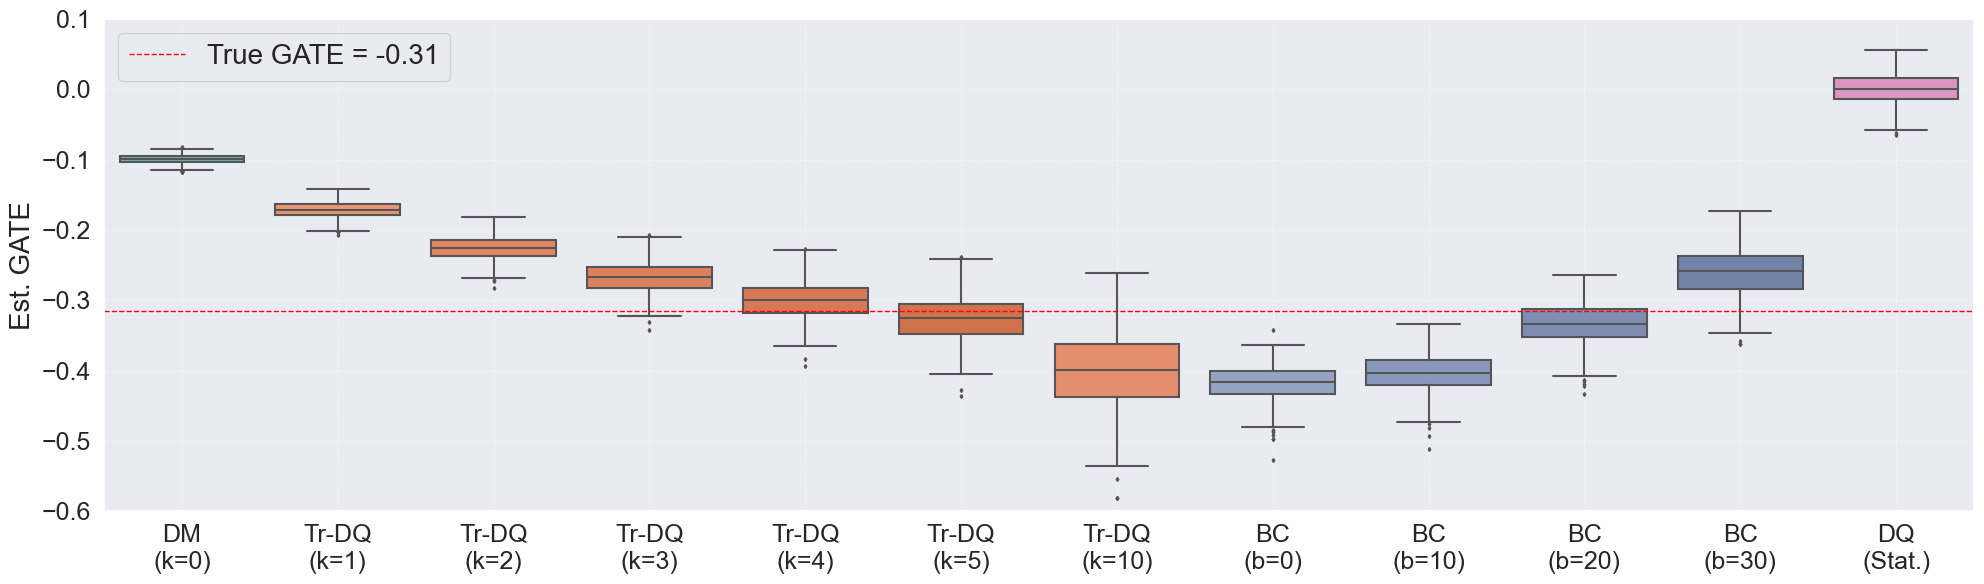

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import colorsys
from collections import defaultdict

sns.set()

# --- Define subtle tinting function ---
def tint_color(color, intensity=1.0):
    """
    Slightly darkens the base color.
    intensity = 1.0 -> original color, <1.0 -> slightly darker.
    """
    r, g, b = color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = l * (0.4 + 0.6 * intensity)
    s = s * (0.4 + 0.6 * intensity)
    return colorsys.hls_to_rgb(h, l, s)

# --- Base colors per estimator type ---
base_colors = {
    'DM': sns.color_palette("Set2")[0],
    'Tr-DQ': sns.color_palette("Set2")[1],
    'BC': sns.color_palette("Set2")[2],
    'DQ': sns.color_palette("Set2")[3],
    'OPE': sns.color_palette("Set2")[4],
}

# --- Configuration for plotting ---
print("\nPlotting ATE estimate distributions (Box Plot)...")
plt.figure(figsize=(20, 6))

plot_config = {
    "trunc_ht": [0, 1, 2, 3, 4, 5, 10],
    "switchback_dm": False,
    "bc_switchback": [0, 10, 20, 30],
    "include_dq": True,
    "include_ope": False
}

# --- Custom display names ---
name_map = {
    "trunc_ht": {0: "DM\n(k=0)", 1: "Tr-DQ\n(k=1)", 2: "Tr-DQ\n(k=2)", 3: "Tr-DQ\n(k=3)", 4: "Tr-DQ\n(k=4)",
                 5: "Tr-DQ\n(k=5)", 10: "Tr-DQ\n(k=10)"},
    "switchback_dm": "Switchback DM",
    "bc_switchback": {0: "BC\n(b=0)", 10: "BC\n(b=10)", 20: "BC\n(b=20)", 30: "BC\n(b=30)"},
    "dq": "DQ\n(Stat.)",
    "ope": "LSTD-OPE"
}

# --- Collect data and labels ---
plot_data = []
plot_labels = []

for k in plot_config["trunc_ht"]:
    if k in ate_estimates_by_k:
        plot_data.extend(ate_estimates_by_k[k])
        plot_labels.extend([name_map["trunc_ht"][k]] * len(ate_estimates_by_k[k]))

if plot_config["switchback_dm"]:
    plot_data.extend(dm_estimates)
    plot_labels.extend([name_map["switchback_dm"]] * len(dm_estimates))

for b in plot_config["bc_switchback"]:
    if b in bc_estimates_by_burnin:
        plot_data.extend(bc_estimates_by_burnin[b])
        plot_labels.extend([name_map["bc_switchback"][b]] * len(bc_estimates_by_burnin[b]))

if plot_config.get("include_dq", False):
    plot_data.extend(dq_estimates)
    plot_labels.extend([name_map["dq"]] * len(dq_estimates))

if plot_config.get("include_ope", False):
    plot_data.extend(ope_estimates)
    plot_labels.extend([name_map["ope"]] * len(ope_estimates))

# --- Prepare DataFrame ---
df_plot = pd.DataFrame({
    "Estimator": plot_labels,
    "Est. GATE": plot_data
})

# --- Generate shaded color palette ---
def get_type(label):
    if "Tr-DQ" in label:
        return "Tr-DQ"
    elif "DM" in label:
        return "DM"
    elif "BC" in label:
        return "BC"
    elif "DQ" in label:
        return "DQ"
    elif "OPE" in label or "LSTD" in label:
        return "OPE"
    else:
        return "Unknown"

label_color_map = {}
type_counts = defaultdict(int)
type_total = defaultdict(int)

for label in df_plot["Estimator"].unique():
    type_total[get_type(label)] += 1

for label in sorted(df_plot["Estimator"].unique()):
    est_type = get_type(label)
    idx = type_counts[est_type]
    total = max(type_total[est_type] - 1, 1)
    intensity = 1.0 - 0.3 * idx / total  # From 1.0 (base) to 0.7
    label_color_map[label] = tint_color(base_colors[est_type], intensity=intensity)
    type_counts[est_type] += 1

# --- Create box plot ---
sns.boxplot(data=df_plot, x="Estimator", y="Est. GATE", palette=label_color_map, fliersize=2)

# Add true ATE line
plt.axhline(true_ATE, color='red', linestyle='--', linewidth=1, label=f"True GATE = {true_ATE:.2f}")

# Formatting
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Est. GATE", fontsize=20)
plt.xlabel("")
plt.legend(fontsize=20)
plt.ylim(-0.6, 0.1)
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()

# Save and show
filename = "plots/queue_boxplot.pdf"
plt.savefig(filename)
print(f"Saved box plot to {filename}")
plt.show()
